# 1. Starting point

Input: (256, 256, 3) Chest X-ray image 566개
<br>
Label: 좌우 lung 마스킹되어 있는 흑백 이미지 566개
<br><br>
이미지 기준 좌측 폐: Right lung
이미지 기준 우측 폐: Left lung
<br>
※ Task<br>
&nbsp;&nbsp;&nbsp;    - Left lung, Right lung 분할(2 classes + 1 class(background)) <br>
&nbsp;&nbsp;&nbsp;    - 훈련 & 추론 + 후처리(보간법) 노이즈 제거(예측 성능 ↑)

## 데이터 구조

data <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└ image/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        ... <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└ label/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        ...    

## 사전 작업

label 폴더의 마스킹 이미지를 각각 좌측 폐('label_rl/l/*'), 우측 폐'label_rl/r/*'로 분할하여 어노테이션 처리하였습니다.<br>
추후 작업 시 라벨링을 배경: 0, 좌측 폐: 1, 우측 폐: 2로 하고 다시 one-hot encoding 작업으로 분할하여 진행한다.

# 2. Library Import

In [1]:
import os
import time
import datetime
import pickle
import statistics
import copy
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Add, Input, Dense, Conv2D, Flatten, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 3. Data Preprocessing

In [2]:
# fix random seed for reproductibility
seed = 777
np.random.seed(seed)
tf.random.set_seed(seed)

# hyper parameter
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
N_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
# Input, Label making
input_path = './data/image/'
input_files = os.listdir(input_path)
label_path = './data/label/'
label_files = os.listdir(label_path)
half_width = int(IMG_WIDTH/2)

X_all = np.zeros((len(input_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                  dtype=np.uint8) # Input image
y_all = np.zeros((len(label_files), IMG_HEIGHT, IMG_WIDTH, N_CLASSES),
                  dtype=np.bool)  # Label(Mask)

input_count = 0
for input_file in input_files:
    input_img = cv2.imread(input_path + input_file, cv2.IMREAD_GRAYSCALE)
    input_img = np.expand_dims(input_img, axis=-1)
    
    X_all[input_count] = input_img
    input_count += 1

label_count = 0    
for label_file in label_files:
    label_img = cv2.imread(label_path + label_file, cv2.IMREAD_GRAYSCALE)
    
    cnt, mass = cv2.connectedComponents(label_img)
    labels = np.zeros_like(mass) # (256, 256)
    
    for label_cnt, j in enumerate(range(cnt)):
        labels[mass==j] = label_cnt + 10
    
    labels_info = np.unique(labels, return_counts=True)
    labels_index = labels_info[0]
    labels_value = labels_info[1]           
    
    labels_left = labels[:, :half_width]
    left_info = np.unique(labels_left, return_counts=True)
    left_index = left_info[0]
    left_value = left_info[1]
    left_sort = left_value.argsort()
    left_pick = left_index[left_sort[-2]]
    
    labels_right = labels[:, half_width:]
    right_info = np.unique(labels_right, return_counts=True)
    right_index = right_info[0]
    right_value = right_info[1]
    right_sort = right_value.argsort()
    right_pick = right_index[right_sort[-2]]
    
    left_copy = copy.deepcopy(labels)
    right_copy = copy.deepcopy(labels)
    
    left_copy[left_copy!=left_pick] = 0
    left_copy[left_copy==left_pick] = 1
    
    right_copy[right_copy!=right_pick] = 0
    right_copy[right_copy==right_pick] = 1
    
    left_ = np.expand_dims(left_copy, axis=-1)
    right_ = np.expand_dims(right_copy, axis=-1)
    
    concat_label = np.concatenate((left_, right_), axis=2)
    
    y_all[label_count] = concat_label
    label_count += 1

In [4]:
print('X_all shape: ', X_all.shape)
print('y_all shape: ', y_all.shape)

X_all shape:  (566, 256, 256, 1)
y_all shape:  (566, 256, 256, 2)


In [5]:
X_all = X_all.astype('float32') / 255.
y_all = y_all.astype('float32')

In [6]:
# data slicing
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=777)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

print('X_train shape: ', X_train.shape)
print('X_valid shape: ', X_valid.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_valid shape: ', y_valid.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (361, 256, 256, 1)
X_valid shape:  (91, 256, 256, 1)
X_test shape:  (114, 256, 256, 1)
y_train shape:  (361, 256, 256, 2)
y_valid shape:  (91, 256, 256, 2)
y_test shape:  (114, 256, 256, 2)


In [7]:
# def plotTrainData(a,b,c):
#     for i in range(3):
#         ix = np.random.randint(0, len(a))
#         plt.subplot(1,2,1)
#         plt.title("X_" + c)
#         plt.imshow(a[ix])
#         plt.axis('off')
#         plt.subplot(1,2,2)
#         plt.title("y_" + c)
#         plt.imshow(np.squeeze(b[ix]))#, 'gray')
#         plt.axis('off')
#         plt.show()
        
# plotTrainData(X_train,y_train, 'train')
# plotTrainData(X_valid,y_valid, 'valid')
# plotTrainData(X_test,y_test, 'test')

# 4. Modeling(U-Net)

![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

## 4-1. Model

In [8]:
# U-Net model
# 신경망의 끝단을 MLP가 아닌 CNN을 채택함으로서 기존의 MLP에서의 Flatten으로
# 인한 이미지 특성의 보존이 약해지는 것을 보완하고자 하였다.
# Input: (H, W, C)
# Output: FCN을 사용하여,
#         합성곱(분류 클래스 개수, kernel_size, activation)
# 이미지 해상도를 Maxpooling(<-> Upsampling)하여 줄여나가다(채널은 증가)
# Upsampling으로 작아진 해상도를 늘리며 주변 픽셀을 예측해 값을 채운다.
# 가장 특징적인 점은 Skip connection 기법으로 은닉층을 거칠수록 피쳐맵이 형이상학적인 모양을 띄어가는데
# 그 이전에 초반 레이어 단에서의 비교적 단순한 피쳐맵(수평선, 수직선, 곡선같은 모양)을 Concatenate하여
# 후반 레이어 단에 연결시켜 가중치를 더하는 역할을 한다.
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 4-2. Compile & Fit

In [9]:
# Loss function 계산
# dice coefficient영역이 얼마나 겹치는지를(교집합) 판단하여 오차를 계산한다.(=F1 score)
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [12]:
model_h5_path = './model/20211215-135826.h5'

if os.path.isdir('./model'):
    print("model 폴더 존재")
else:
    os.mkdir('./model')
    print("model 폴더 생성")    

if os.path.isfile(model_h5_path):
    print("모델 존재")
    model = load_model(model_h5_path, custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=dice_coef_loss,
                  optimizer=sgd,
                  metrics=[dice_coef])

else:
    print("모델 생성 훈련")
    
    # earlystopping = EarlyStopping(monitor='val_loss', # 'dice_coef_loss를 custom 적용.. 찾기'
    #                               patience=10)
    # modelcheckpoint = ModelCheckpoint(f"./model_ckpt/{time.strftime('%Y%m%d-%H%M%S')}.h5",
    #                                   monitor='val_loss',
    #                                   verbose=1,
    #                                   save_best_only=True,
    #                                   mode='auto')
    
    model = unet()
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=dice_coef_loss,
                  optimizer=sgd,
                  metrics=[dice_coef])
    
    start = time.time()

    hist = model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     verbose=1)
                     # callbacks=[modelcheckpoint, earlystopping])

    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    runtime = runtime[0]
    print(f"Fitting Runtime: {runtime}")

    model.save(f"./model/{time.strftime('%Y%m%d-%H%M%S')}.h5")

model 폴더 존재
모델 존재


## 4-3. Fit Visualization

In [17]:
if os.path.isfile(model_h5_path):
    pass

else:
    # 학습과정 살펴보기
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
    acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('dice_coef')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

# 5. Predictions & Image processing

## 5-1. dice_coeff 값에 따른 데이터 슬라이싱

In [28]:
def savePredicitions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN

    X_train_dc = []
    X_valid_dc = []
    X_test_dc = []
    
    start = time.time()
    
    print("X_train start.")
    for ix in range(len(X_train_)):
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_)
        preds_train_t = (preds_train > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[0]))
#         print("Prediction: %.4f" % (ret[1]))
        X_train_dc.append(ret[1])
    print("X_train completed.")

    print("X_valid start.")
    for ix in range(len(X_valid_)):
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_)
        preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_valid_dc.append(ret[1])
    print("X_valid completed.")

    print("X_test start.")
    for ix in range(len(X_test_)):
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_test_dc.append(ret[1])
    print("X_test completed.")
    
    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    print(f"Runtime: {runtime[0]}")
    
    return X_train_dc, X_valid_dc, X_test_dc

In [29]:
X_dc_pkl_path = './X_dc.pkl'
print(f"X_dc_pkl_path:  {X_dc_pkl_path}")

if os.path.isfile(X_dc_pkl_path):
    print("X_dc_pkl loaded..")
    # pickle file load
    with open('./X_dc.pkl', 'rb') as f:
        X_dc = pickle.load(f)

else:
    print("pkl file creating..")
    X_dc = {}
    X_dc['X_train'], X_dc['X_valid'], X_dc['X_test'] = savePredicitions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

    # pickle file save
    with open('./X_dc.pkl', 'wb') as f:
        pickle.dump(X_dc, f)

X_dc_pkl_path:  ./X_dc.pkl
pkl file creating..
X_train start.
1/1 [==============================] - 0s 84ms/step - loss: 0.0364 - dice_coef: 0.9636
X_train completed.
X_valid start.
1/1 [==============================] - 0s 83ms/step - loss: 0.0440 - dice_coef: 0.9560
X_valid completed.
X_test start.
1/1 [==============================] - 0s 91ms/step - loss: 0.0291 - dice_coef: 0.9709
X_test completed.
Runtime: 0:01:52


In [30]:
print("X_train 평균값: ", statistics.mean(X_dc['X_train'])) # print(np.mean(X_dc['X_train']))
print("X_train 최대값: ", np.max(X_dc['X_train'])) # np.min(X_dc['X_train'])
print("X_train 최소값: ", np.min(X_dc['X_train'])) # np.max(X_dc['X_train'])
print()
print("X_valid 평균값: ", statistics.mean(X_dc['X_valid']))
print("X_valid 최대값: ", np.max(X_dc['X_valid']))
print("X_valid 최소값: ", np.min(X_dc['X_valid']))
print()
print("X_test 평균값: ", statistics.mean(X_dc['X_test']))
print("X_test 최대값: ", np.max(X_dc['X_test']))
print("X_test 최소값: ", np.min(X_dc['X_test']))

X_train 평균값:  0.9513208018280462
X_train 최대값:  0.9806734919548035
X_train 최소값:  0.2501111924648285

X_valid 평균값:  0.946805843940148
X_valid 최대값:  0.9754765629768372
X_valid 최소값:  0.78547602891922

X_test 평균값:  0.9452593227227529
X_test 최대값:  0.9785815477371216
X_test 최소값:  0.798682451248169


In [31]:
def dice_coef_slice(data, df_type, threshold, *args):#approach):
    '''
    1. data: dice_coef list를 가진 변수
       └> ex) X_dc['X_train'], X_dc['X_valid'], X_dc['X_test']
       
    2. df_type: 실제 얻을 데이터의 전체 데이터
       └> ex) X_train, X_valid, X_test, y_train, y_valid, y_test
       
    3. threshold: dice_coef 임계값
       └> ex) 
              case 1) [0.9] 
       [0.7, 0.9]
    
    4. *args 인자('up' or 'down'): threshold 값 위로 잡을지 아래로 잡을지 결정한다.
       └> ex) 'up' or 'down' 중 하나 선택(※ 임계값(threshold)이 없으면 비어있는 인자
    
    5. return 값(box, idx_box 2개가 리턴됩니다.)
       └> ex)
              case 1) dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down'
                      └> box: X_dc['X_train']의 의 리스트에 있는 dice_coef 값 중 0.95 아래인 것의 인덱스(idx)를 찾아
                              y_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
              
              case 2) dice_coef_slice(X_dc['X_train'], X_train, [0.95, 0.96])
                      └> box: X_dc['X_train']의 리스트에 있는 dice_coef 값 중 0.95 ~ 0.96 사이의 인덱스(idx)를 찾아
                              X_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
    '''
    
    box = []
    idx_box = []
    
    if len(threshold) == 1:
        if args[0] == 'up': # if approach == 'up':
            for idx, value in enumerate(data):
                if value >= threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)
            box = np.array(box)
            return box, idx_box
    
        elif args[0] == 'down': # elif approach == 'down':
            for idx, value in enumerate(data):
                if value < threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)                    
            box = np.array(box)
            return box, idx_box
    
        else:
            return print("Approach value Error!")
        
    elif len(threshold) == 2:
        for idx, value in enumerate(data):
            if value >= threshold[0] and value < threshold[1]:
                box.append(df_type[idx])
                idx_box.append(idx)
        box = np.array(box)
        return box, idx_box
    
    else:
        return print("Threshold value Error!")

In [32]:
X_train_095_down, X_train_095_down_idx = dice_coef_slice(X_dc['X_train'], X_train, [0.95], 'down')
X_valid_095_down, X_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], X_valid, [0.95], 'down')
X_test_095_down, X_test_095_down_idx = dice_coef_slice(X_dc['X_test'], X_test, [0.95], 'down')

y_train_095_down, y_train_095_down_idx = dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down')
y_valid_095_down, y_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], y_valid, [0.95], 'down')
y_test_095_down, y_test_095_down_idx = dice_coef_slice(X_dc['X_test'], y_test, [0.95], 'down')

In [33]:
print(X_train_095_down.shape)
print(X_valid_095_down.shape)
print(X_test_095_down.shape)

print(y_train_095_down.shape)
print(y_valid_095_down.shape)
print(y_test_095_down.shape)

print(X_train_095_down_idx)
print(X_valid_095_down_idx)
print(X_test_095_down_idx)

print(y_train_095_down_idx)
print(y_valid_095_down_idx)
print(y_test_095_down_idx)

(92, 256, 256, 1)
(34, 256, 256, 1)
(51, 256, 256, 1)
(92, 256, 256, 2)
(34, 256, 256, 2)
(51, 256, 256, 2)
[2, 13, 16, 22, 24, 32, 40, 43, 52, 56, 70, 72, 79, 80, 81, 102, 106, 110, 113, 117, 118, 120, 123, 125, 127, 132, 133, 134, 139, 141, 143, 146, 149, 151, 156, 159, 165, 166, 168, 169, 175, 179, 189, 196, 198, 200, 205, 206, 214, 222, 234, 236, 237, 239, 240, 243, 249, 254, 258, 260, 262, 267, 268, 273, 281, 282, 283, 285, 288, 289, 293, 298, 304, 305, 308, 309, 310, 313, 316, 317, 320, 322, 323, 324, 337, 338, 347, 348, 353, 354, 357, 359]
[0, 3, 6, 7, 10, 16, 22, 24, 29, 34, 35, 37, 39, 40, 44, 45, 46, 51, 54, 55, 57, 62, 64, 65, 67, 69, 73, 74, 81, 82, 83, 84, 86, 87]
[0, 1, 2, 4, 5, 12, 14, 15, 19, 20, 24, 25, 29, 30, 31, 34, 39, 40, 41, 44, 49, 50, 51, 53, 57, 58, 59, 60, 61, 62, 63, 67, 69, 70, 73, 75, 76, 78, 79, 80, 86, 87, 89, 94, 101, 105, 106, 107, 109, 111, 112]
[2, 13, 16, 22, 24, 32, 40, 43, 52, 56, 70, 72, 79, 80, 81, 102, 106, 110, 113, 117, 118, 120, 123, 125, 12

In [34]:
print(len(X_test_095_down_idx))

51


## 5-2. 일반 예측

In [39]:
# def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
def plotPredictions(X_test_, y_test_, useModel):
    model = useModel
    
    print("▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶")
    for ix in range(len(X_test_)):
        print(f"-------------------------------- ix: {ix}   --------------------------------")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.3).astype(np.uint8)

        for i in range(2):
            if i == 0:
                comment = "Left lung"
            elif i == 1:
                comment = "Right lung"
                
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_test")
            plt.axis('off')
            plt.imshow(input_[0], 'gray')

            plt.subplot(1,3,2)
            plt.title(f"Y_test  ({comment})")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"-------------------------------------------------------------------------")
    print("◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀")

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
-------------------------------- ix: 0   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.1483 - dice_coef: 0.8517


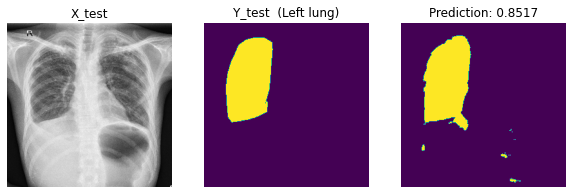

1/1 [==============================] - 0s 84ms/step - loss: 0.1483 - dice_coef: 0.8517


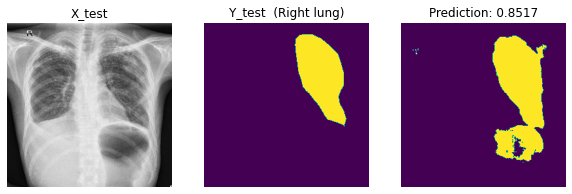

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀


In [40]:
plotPredictions(X_test[39:40], y_test[39:40], model)

## 5-?. Prediction Visualization

In [47]:
# def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
def plotPredictions(X_test_, y_test_, useModel):
    model = useModel

    print("▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶")
    for ix in range(len(X_test_)):
        print(f"-------------------------------- ix: {ix}   --------------------------------")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.99).astype(np.uint8)
        # preds_test_t = (preds_test > 0.5).astype(np.uint8)

        for i in range(2):
            if i == 0:
                comment = "Left lung"
            elif i == 1:
                comment = "Right lung"
                
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_test")
            plt.axis('off')
            plt.imshow(input_[0], 'gray')

            plt.subplot(1,3,2)
            plt.title(f"Y_test  ({comment})")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"-------------------------------------------------------------------------")
    print("◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀")

### 5-?-?. 전체 데이터

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


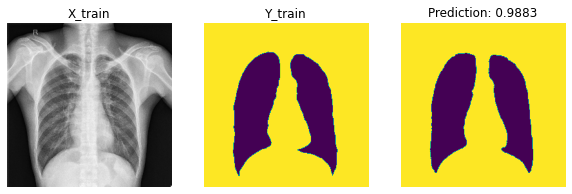

1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


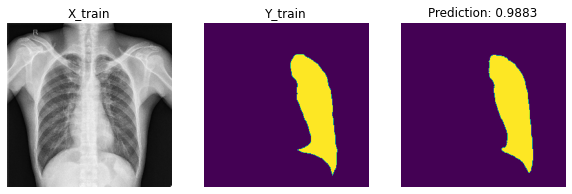

1/1 [==============================] - 0s 16ms/step - loss: 0.0117 - dice_coef: 0.9883


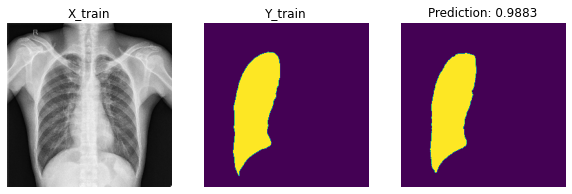

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 26ms/step - loss: 0.0444 - dice_coef: 0.9556


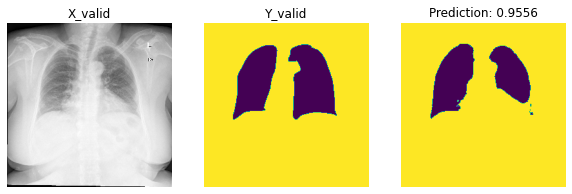

1/1 [==============================] - 0s 22ms/step - loss: 0.0444 - dice_coef: 0.9556


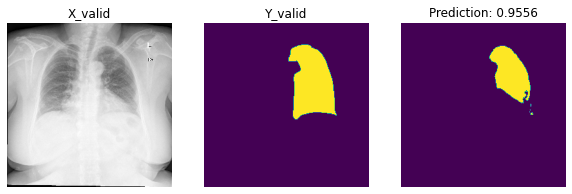

1/1 [==============================] - 0s 31ms/step - loss: 0.0444 - dice_coef: 0.9556


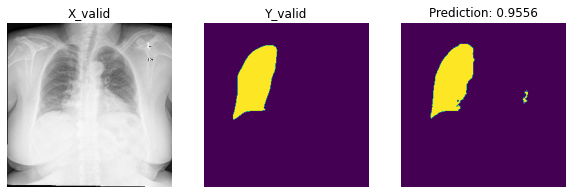

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 28ms/step - loss: 0.0167 - dice_coef: 0.9833


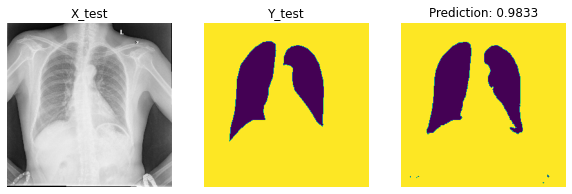

1/1 [==============================] - 0s 26ms/step - loss: 0.0167 - dice_coef: 0.9833


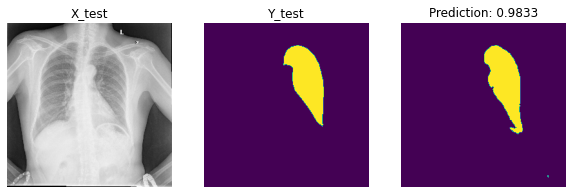

1/1 [==============================] - 0s 16ms/step - loss: 0.0167 - dice_coef: 0.9833


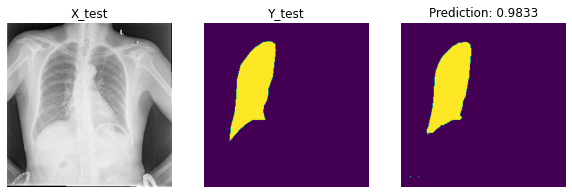

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


In [245]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

### 5-?-?. 낮은 dice_coef(0.95↓) case plot

X_train |&nbsp;&nbsp; length:  15, list index:&nbsp;&nbsp;[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
<br>
X_valid |&nbsp;&nbsp; length:  11, list index:&nbsp;&nbsp;[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
<br>
X_test&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; length: 7, &nbsp;&nbsp;list index:&nbsp;&nbsp;[19, 25, 34, 39, 57, 67, 109]

- test 데이터 기준 0.95 미만
    - 폐 영역 파임(외부): 0(좌우), 1(좌), 4(좌 조금), 5(좌)
    - 폐 영역 파임(내부): 2(좌우)
    - 노이즈: 3(좌)
    - 특이 케이스: 6

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
-------------------------------- ix: 0   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 85ms/step - loss: 0.0519 - dice_coef: 0.9481


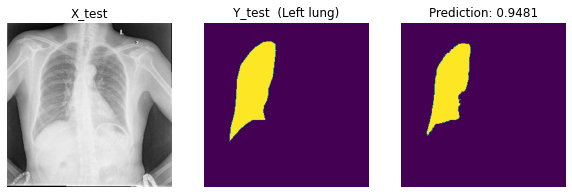

1/1 [==============================] - 0s 84ms/step - loss: 0.0519 - dice_coef: 0.9481


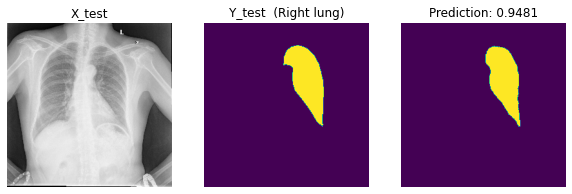

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 1   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 101ms/step - loss: 0.0826 - dice_coef: 0.9174


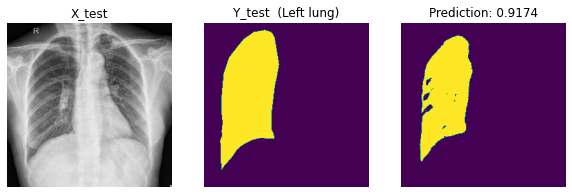

1/1 [==============================] - 0s 88ms/step - loss: 0.0826 - dice_coef: 0.9174


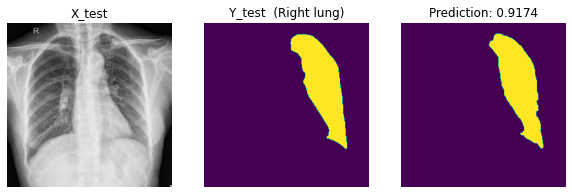

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 2   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 76ms/step - loss: 0.0521 - dice_coef: 0.9479


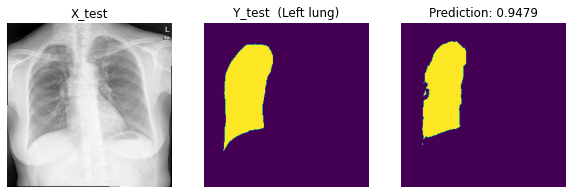

1/1 [==============================] - 0s 88ms/step - loss: 0.0521 - dice_coef: 0.9479


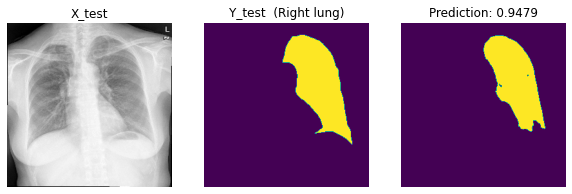

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 3   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 92ms/step - loss: 0.0594 - dice_coef: 0.9406


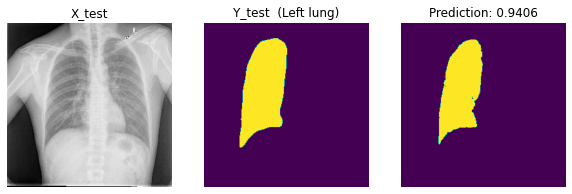

1/1 [==============================] - 0s 82ms/step - loss: 0.0594 - dice_coef: 0.9406


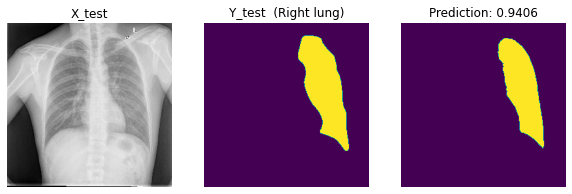

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 4   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.0607 - dice_coef: 0.9393


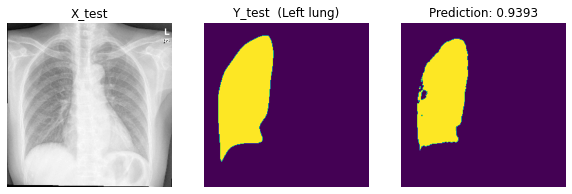

1/1 [==============================] - 0s 91ms/step - loss: 0.0607 - dice_coef: 0.9393


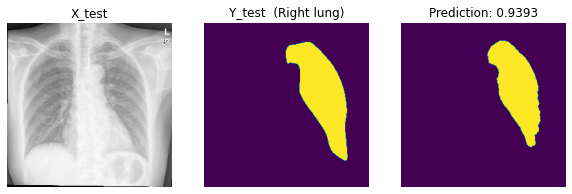

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 5   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 81ms/step - loss: 0.0545 - dice_coef: 0.9455


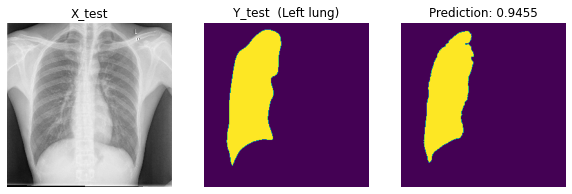

1/1 [==============================] - 0s 86ms/step - loss: 0.0545 - dice_coef: 0.9455


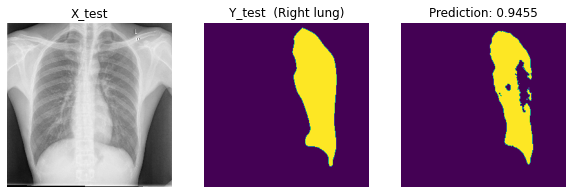

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 6   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 103ms/step - loss: 0.0628 - dice_coef: 0.9372


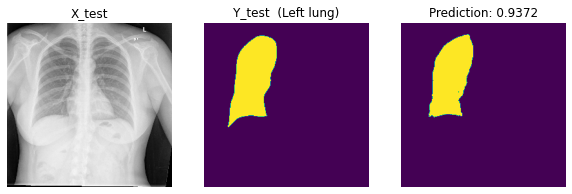

1/1 [==============================] - 0s 90ms/step - loss: 0.0628 - dice_coef: 0.9372


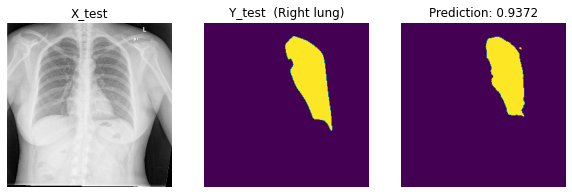

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 7   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 93ms/step - loss: 0.1565 - dice_coef: 0.8435


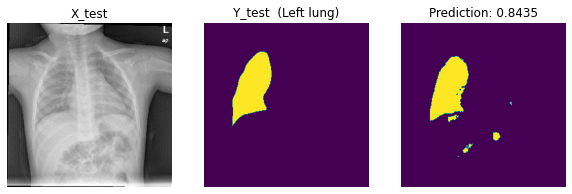

1/1 [==============================] - 0s 86ms/step - loss: 0.1565 - dice_coef: 0.8435


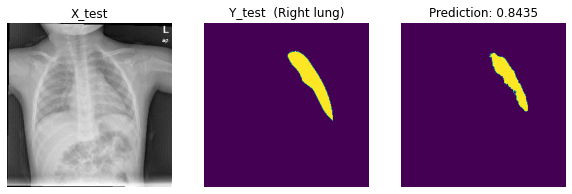

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 8   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 91ms/step - loss: 0.2013 - dice_coef: 0.7987


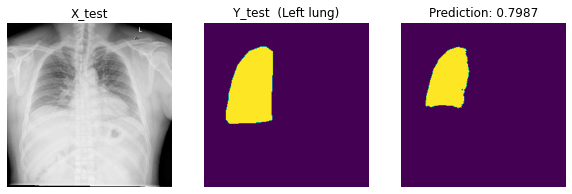

1/1 [==============================] - 0s 73ms/step - loss: 0.2013 - dice_coef: 0.7987


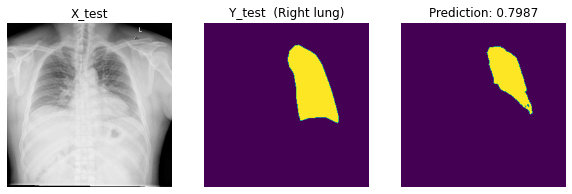

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 9   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 91ms/step - loss: 0.0517 - dice_coef: 0.9483


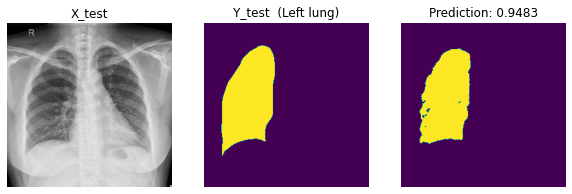

1/1 [==============================] - 0s 89ms/step - loss: 0.0517 - dice_coef: 0.9483


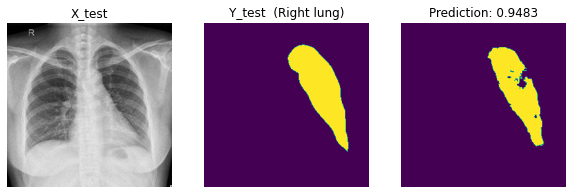

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 10   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 92ms/step - loss: 0.0555 - dice_coef: 0.9445


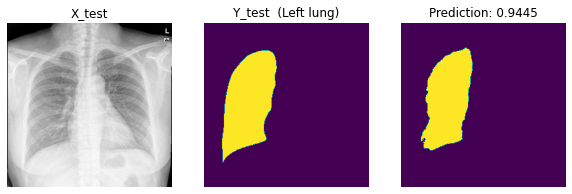

1/1 [==============================] - 0s 84ms/step - loss: 0.0555 - dice_coef: 0.9445


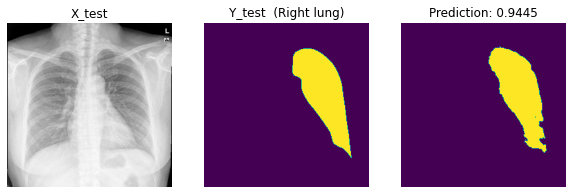

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 11   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 11 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 106ms/step - loss: 0.1156 - dice_coef: 0.8844


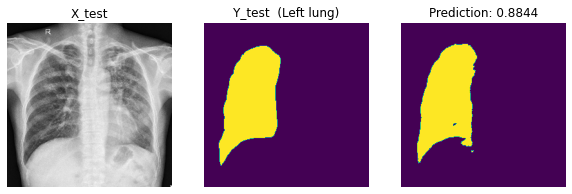

1/1 [==============================] - 0s 104ms/step - loss: 0.1156 - dice_coef: 0.8844


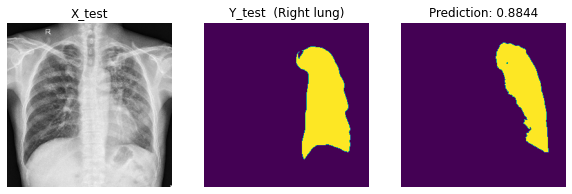

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 11 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 12   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 12 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 95ms/step - loss: 0.0522 - dice_coef: 0.9478


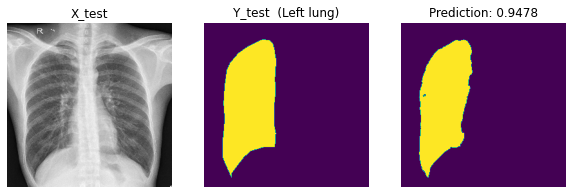

1/1 [==============================] - 0s 93ms/step - loss: 0.0522 - dice_coef: 0.9478


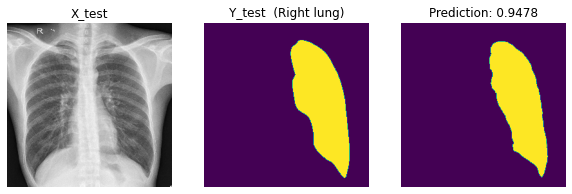

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 12 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 13   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 13 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.0542 - dice_coef: 0.9458


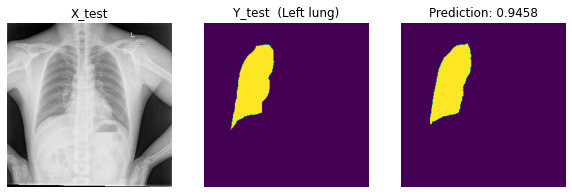

1/1 [==============================] - 0s 91ms/step - loss: 0.0542 - dice_coef: 0.9458


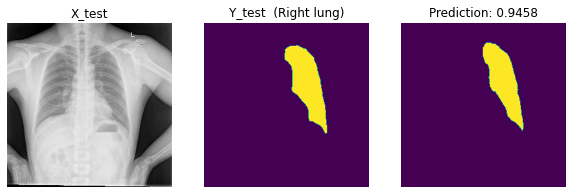

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 13 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 14   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 14 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 92ms/step - loss: 0.0739 - dice_coef: 0.9261


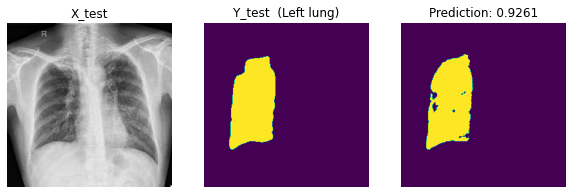

1/1 [==============================] - 0s 73ms/step - loss: 0.0739 - dice_coef: 0.9261


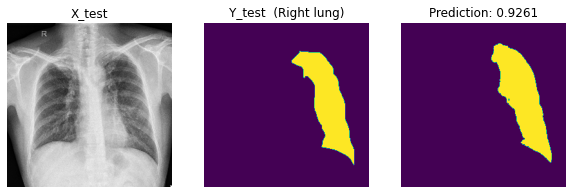

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 14 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 15   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 15 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 88ms/step - loss: 0.1029 - dice_coef: 0.8971


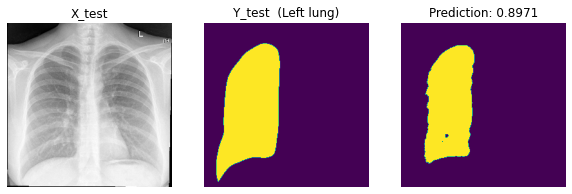

1/1 [==============================] - 0s 86ms/step - loss: 0.1029 - dice_coef: 0.8971


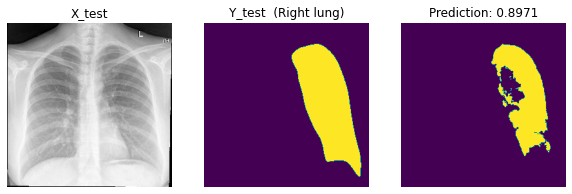

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 15 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 16   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 16 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.1483 - dice_coef: 0.8517


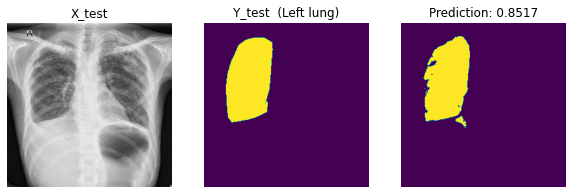

1/1 [==============================] - 0s 87ms/step - loss: 0.1483 - dice_coef: 0.8517


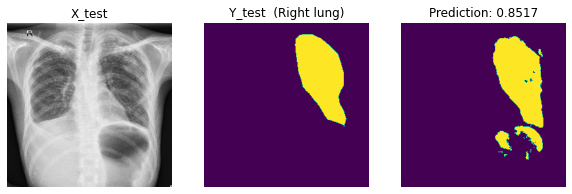

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 16 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 17   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 17 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.0807 - dice_coef: 0.9193


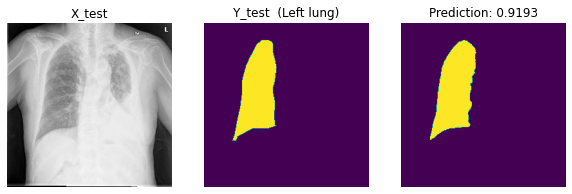

1/1 [==============================] - 0s 86ms/step - loss: 0.0807 - dice_coef: 0.9193


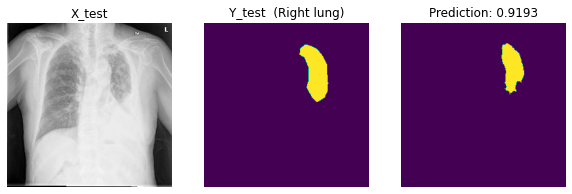

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 17 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 18   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 18 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.0582 - dice_coef: 0.9418


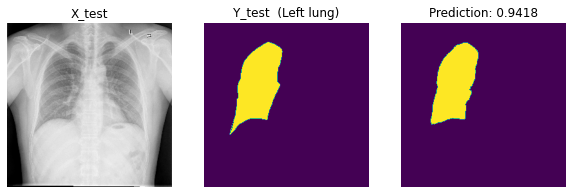

1/1 [==============================] - 0s 85ms/step - loss: 0.0582 - dice_coef: 0.9418


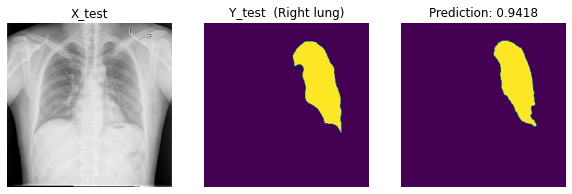

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 18 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 19   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 19 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.1314 - dice_coef: 0.8686


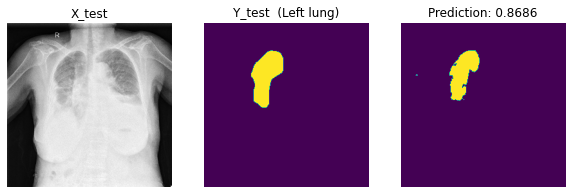

1/1 [==============================] - 0s 93ms/step - loss: 0.1314 - dice_coef: 0.8686


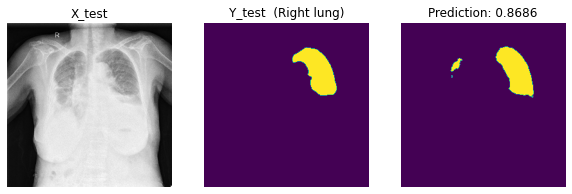

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 19 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 20   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 20 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 99ms/step - loss: 0.0752 - dice_coef: 0.9248


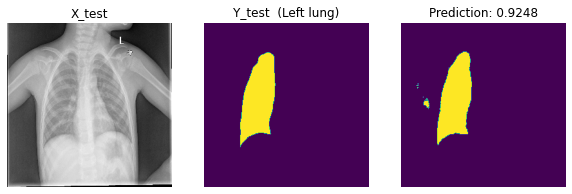

1/1 [==============================] - 0s 73ms/step - loss: 0.0752 - dice_coef: 0.9248


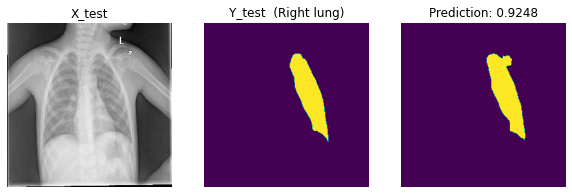

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 20 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 21   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 21 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.1090 - dice_coef: 0.8910


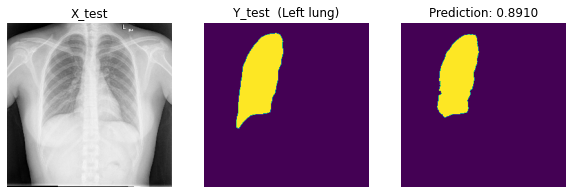

1/1 [==============================] - 0s 77ms/step - loss: 0.1090 - dice_coef: 0.8910


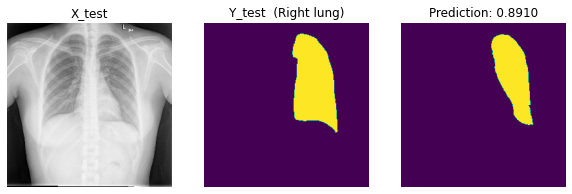

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 21 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 22   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 22 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 106ms/step - loss: 0.0546 - dice_coef: 0.9454


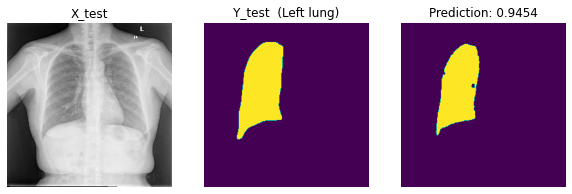

1/1 [==============================] - 0s 85ms/step - loss: 0.0546 - dice_coef: 0.9454


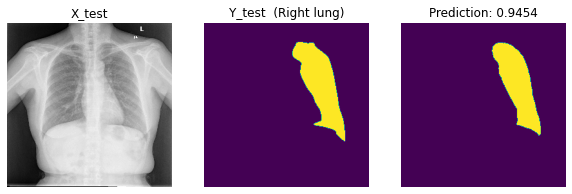

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 22 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 23   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 23 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 96ms/step - loss: 0.0590 - dice_coef: 0.9410


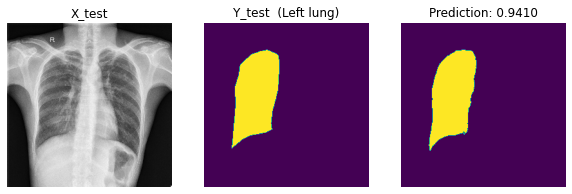

1/1 [==============================] - 0s 93ms/step - loss: 0.0590 - dice_coef: 0.9410


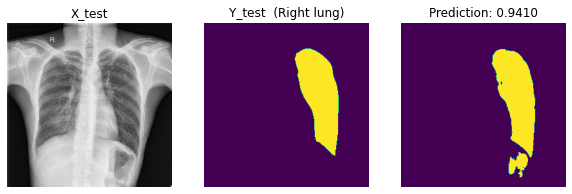

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 23 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 24   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 24 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 97ms/step - loss: 0.1106 - dice_coef: 0.8894


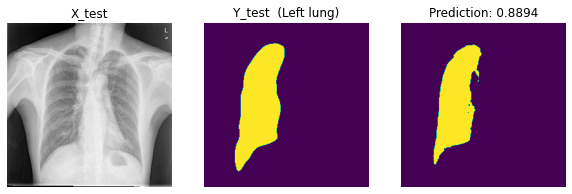

1/1 [==============================] - 0s 87ms/step - loss: 0.1106 - dice_coef: 0.8894


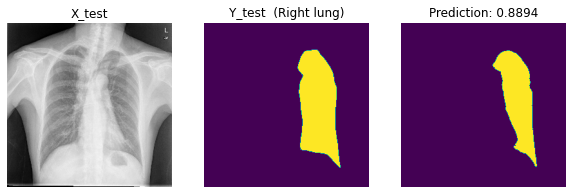

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 24 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 25   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 25 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.0605 - dice_coef: 0.9395


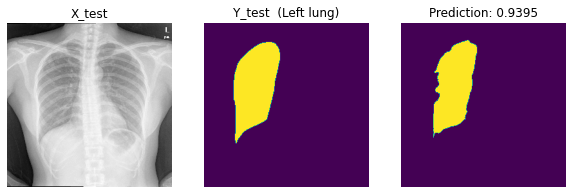

1/1 [==============================] - 0s 76ms/step - loss: 0.0605 - dice_coef: 0.9395


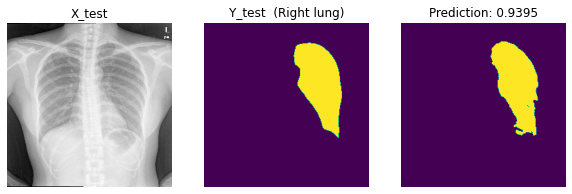

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 25 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 26   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 26 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 86ms/step - loss: 0.0629 - dice_coef: 0.9371


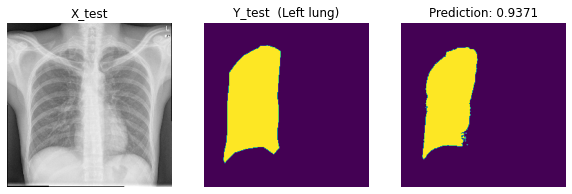

1/1 [==============================] - 0s 70ms/step - loss: 0.0629 - dice_coef: 0.9371


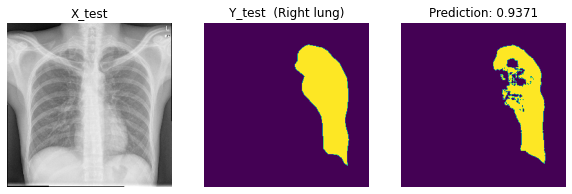

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 26 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 27   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 27 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.0534 - dice_coef: 0.9466


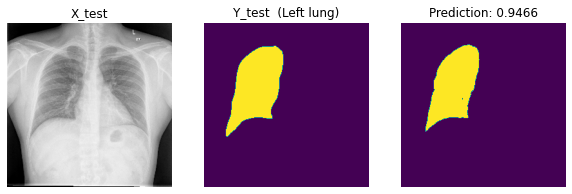

1/1 [==============================] - 0s 93ms/step - loss: 0.0534 - dice_coef: 0.9466


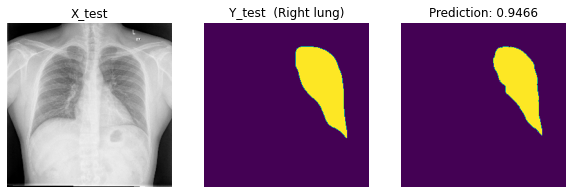

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 27 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 28   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 28 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 106ms/step - loss: 0.0705 - dice_coef: 0.9295


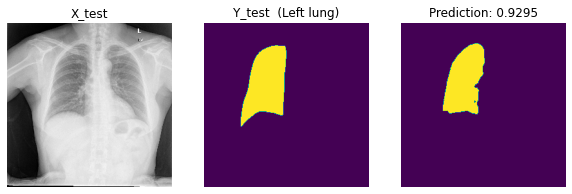

1/1 [==============================] - 0s 73ms/step - loss: 0.0705 - dice_coef: 0.9295


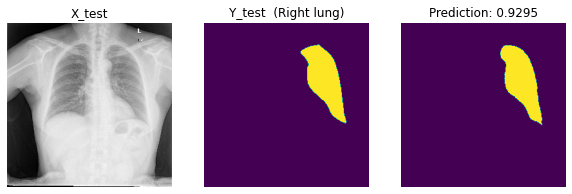

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 28 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 29   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 29 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 88ms/step - loss: 0.0505 - dice_coef: 0.9495


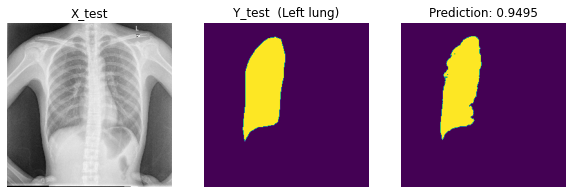

1/1 [==============================] - 0s 103ms/step - loss: 0.0505 - dice_coef: 0.9495


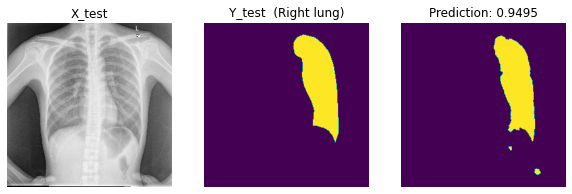

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 29 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 30   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 30 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 79ms/step - loss: 0.0902 - dice_coef: 0.9098


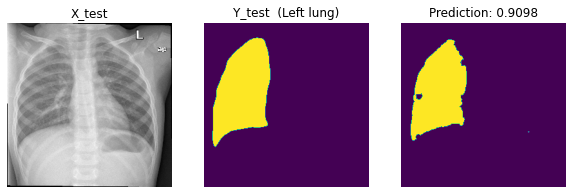

1/1 [==============================] - 0s 75ms/step - loss: 0.0902 - dice_coef: 0.9098


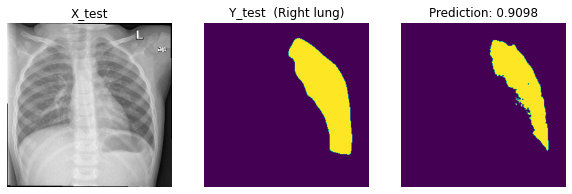

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 30 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 31   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 31 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 93ms/step - loss: 0.1179 - dice_coef: 0.8821


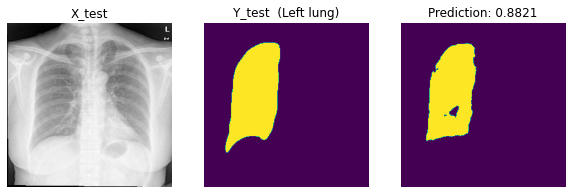

1/1 [==============================] - 0s 85ms/step - loss: 0.1179 - dice_coef: 0.8821


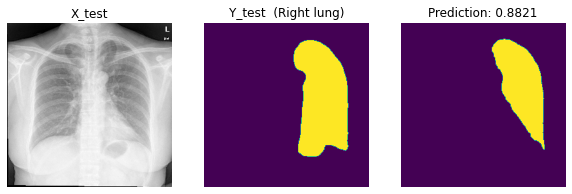

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 31 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 32   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 32 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 102ms/step - loss: 0.0528 - dice_coef: 0.9472


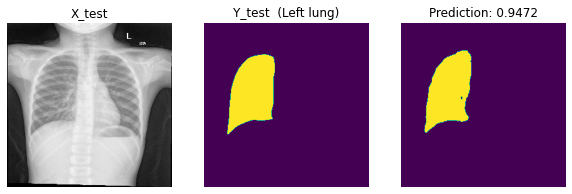

1/1 [==============================] - 0s 90ms/step - loss: 0.0528 - dice_coef: 0.9472


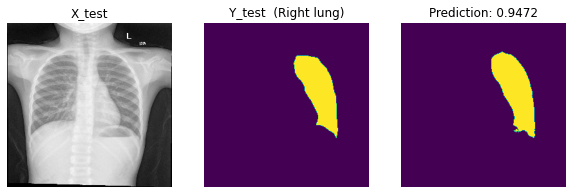

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 32 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 33   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 33 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.0580 - dice_coef: 0.9420


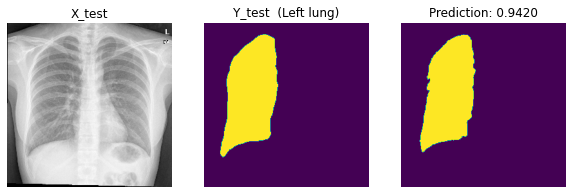

1/1 [==============================] - 0s 88ms/step - loss: 0.0580 - dice_coef: 0.9420


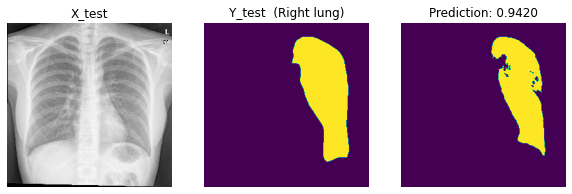

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 33 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 34   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 34 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 91ms/step - loss: 0.0935 - dice_coef: 0.9065


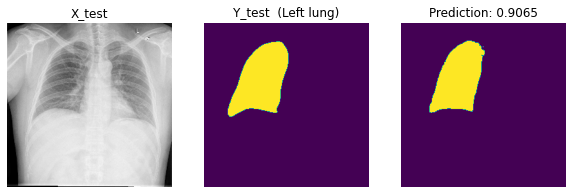

1/1 [==============================] - 0s 78ms/step - loss: 0.0935 - dice_coef: 0.9065


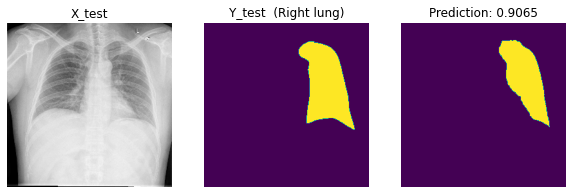

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 34 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 35   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 35 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 83ms/step - loss: 0.0932 - dice_coef: 0.9068


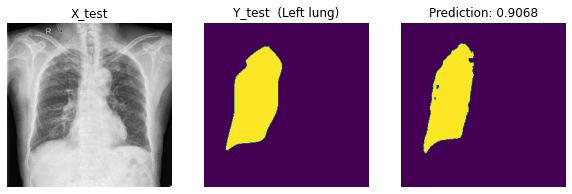

1/1 [==============================] - 0s 91ms/step - loss: 0.0932 - dice_coef: 0.9068


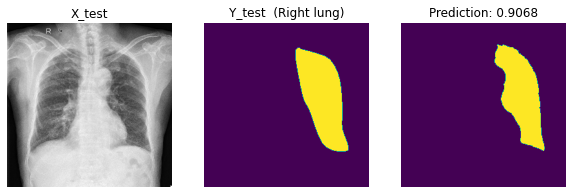

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 35 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 36   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 36 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 101ms/step - loss: 0.0741 - dice_coef: 0.9259


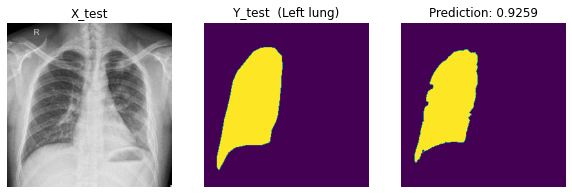

1/1 [==============================] - 0s 85ms/step - loss: 0.0741 - dice_coef: 0.9259


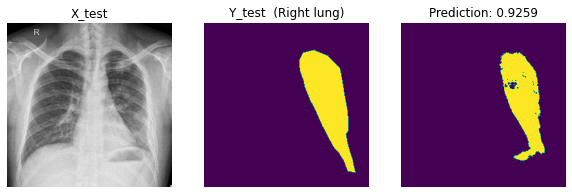

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 36 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 37   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 37 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.0529 - dice_coef: 0.9471


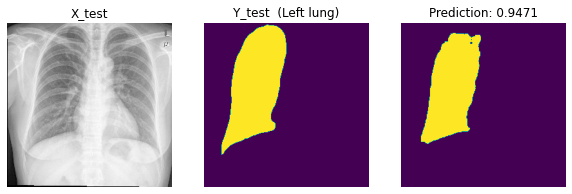

1/1 [==============================] - 0s 82ms/step - loss: 0.0529 - dice_coef: 0.9471


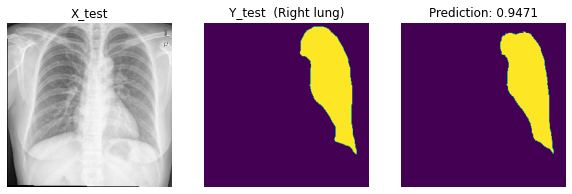

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 37 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 38   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 38 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 100ms/step - loss: 0.0607 - dice_coef: 0.9393


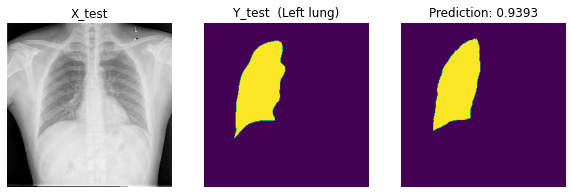

1/1 [==============================] - 0s 80ms/step - loss: 0.0607 - dice_coef: 0.9393


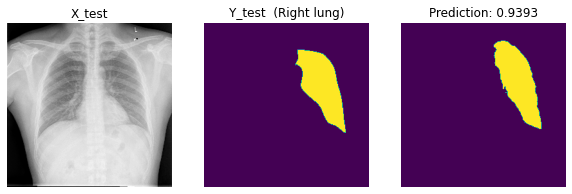

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 38 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 39   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 39 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.0622 - dice_coef: 0.9378


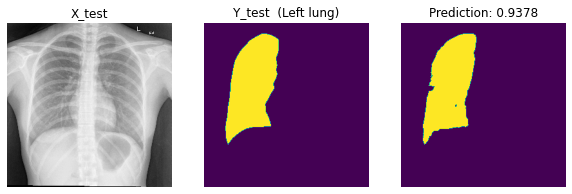

1/1 [==============================] - 0s 77ms/step - loss: 0.0622 - dice_coef: 0.9378


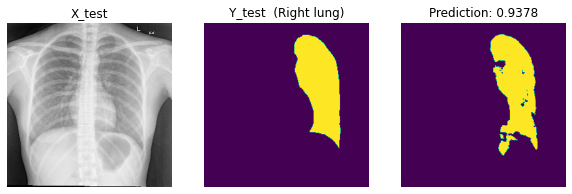

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 39 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 40   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 40 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 86ms/step - loss: 0.0761 - dice_coef: 0.9239


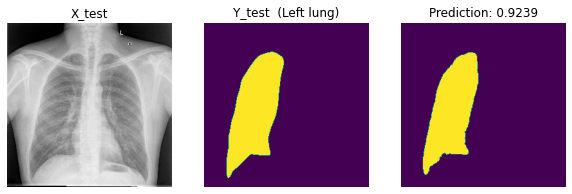

1/1 [==============================] - 0s 78ms/step - loss: 0.0761 - dice_coef: 0.9239


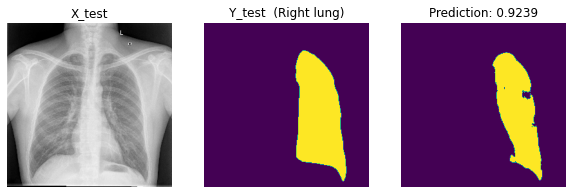

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 40 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 41   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 41 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 88ms/step - loss: 0.0767 - dice_coef: 0.9233


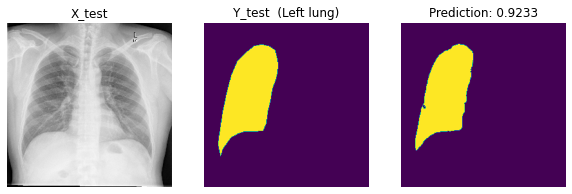

1/1 [==============================] - 0s 80ms/step - loss: 0.0767 - dice_coef: 0.9233


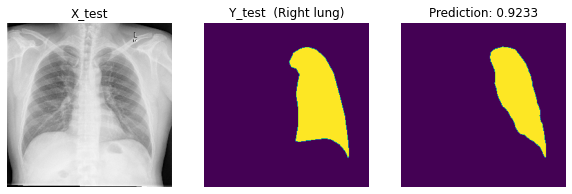

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 41 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 42   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 42 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 88ms/step - loss: 0.0663 - dice_coef: 0.9337


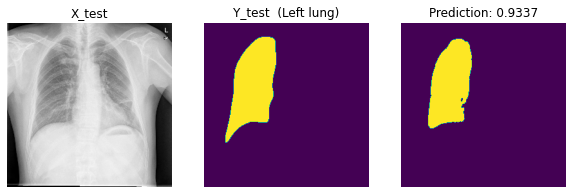

1/1 [==============================] - 0s 83ms/step - loss: 0.0663 - dice_coef: 0.9337


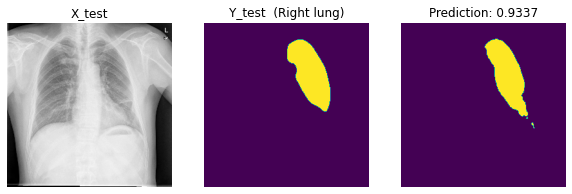

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 42 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 43   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 43 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 78ms/step - loss: 0.0853 - dice_coef: 0.9147


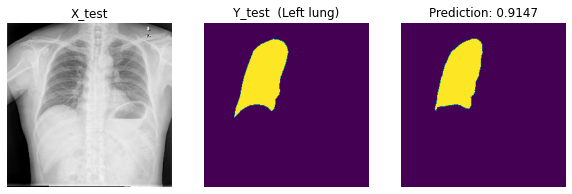

1/1 [==============================] - 0s 87ms/step - loss: 0.0853 - dice_coef: 0.9147


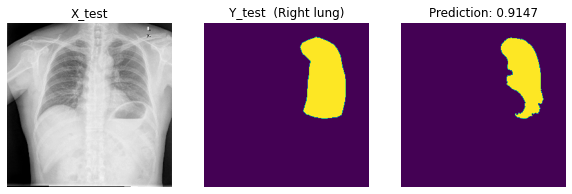

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 43 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 44   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 44 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.0518 - dice_coef: 0.9482


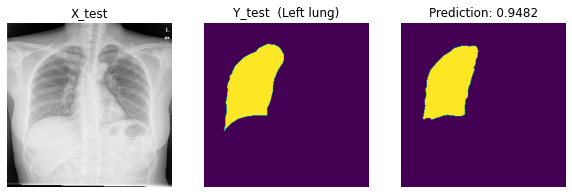

1/1 [==============================] - 0s 85ms/step - loss: 0.0518 - dice_coef: 0.9482


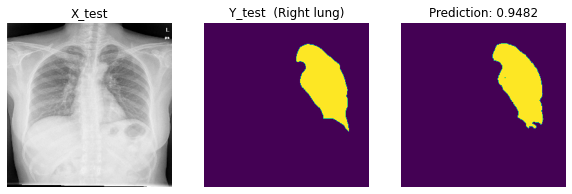

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 44 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 45   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 45 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 78ms/step - loss: 0.0564 - dice_coef: 0.9436


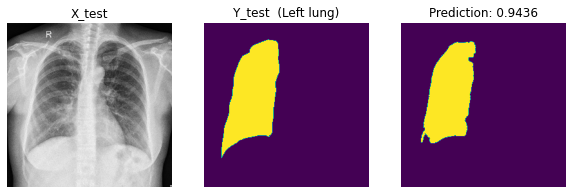

1/1 [==============================] - 0s 98ms/step - loss: 0.0564 - dice_coef: 0.9436


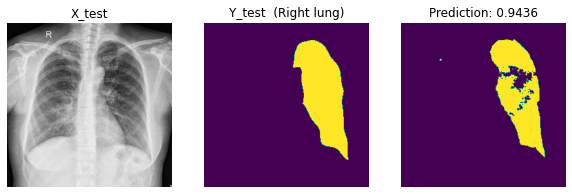

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 45 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 46   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 46 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 97ms/step - loss: 0.0531 - dice_coef: 0.9469


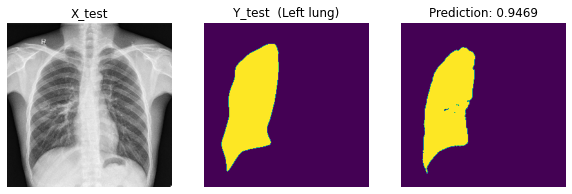

1/1 [==============================] - 0s 92ms/step - loss: 0.0531 - dice_coef: 0.9469


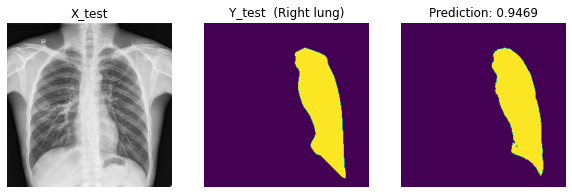

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 46 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 47   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 47 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 87ms/step - loss: 0.0507 - dice_coef: 0.9493


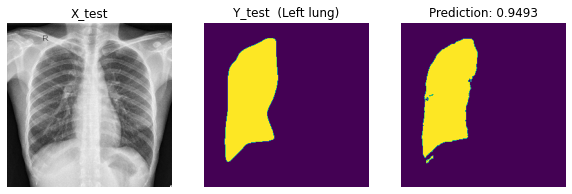

1/1 [==============================] - 0s 90ms/step - loss: 0.0507 - dice_coef: 0.9493


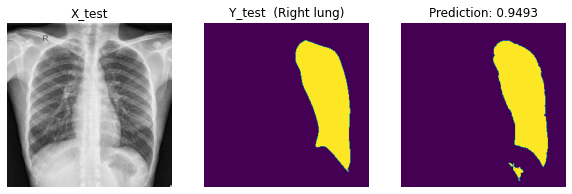

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 47 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 48   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 48 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 93ms/step - loss: 0.0953 - dice_coef: 0.9047


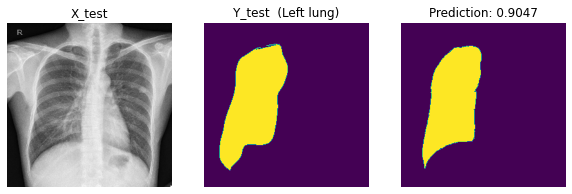

1/1 [==============================] - 0s 88ms/step - loss: 0.0953 - dice_coef: 0.9047


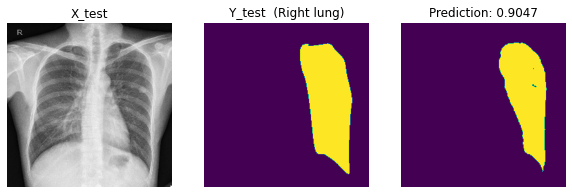

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 48 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 49   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 49 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 94ms/step - loss: 0.0662 - dice_coef: 0.9338


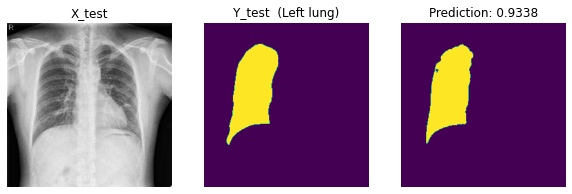

1/1 [==============================] - 0s 71ms/step - loss: 0.0662 - dice_coef: 0.9338


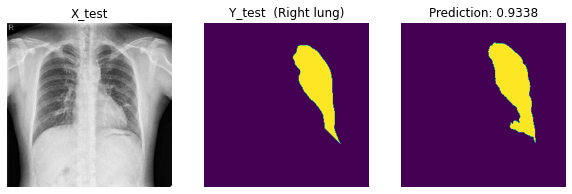

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 49 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 50   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 50 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 102ms/step - loss: 0.0603 - dice_coef: 0.9397


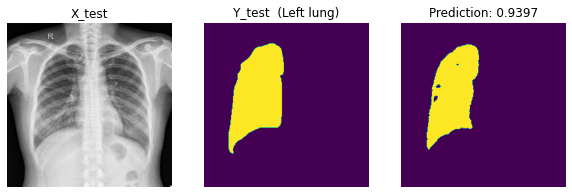

1/1 [==============================] - 0s 95ms/step - loss: 0.0603 - dice_coef: 0.9397


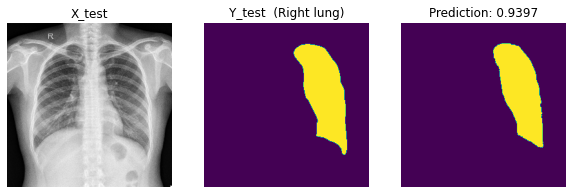

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 50 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀


In [48]:
plotPredictions(X_test_095_down, y_test_095_down, model)